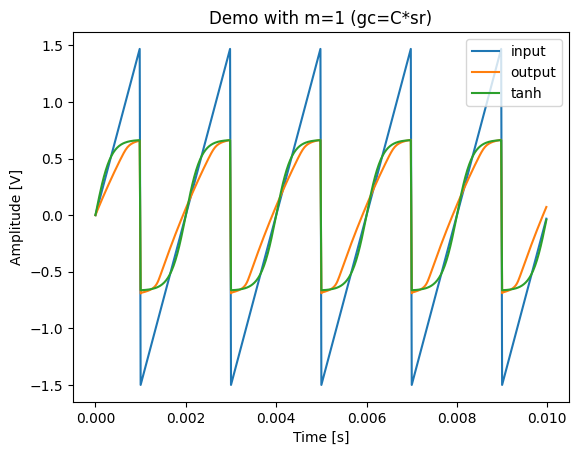

In [38]:
import numpy as np
import matplotlib.pyplot as plt

class SimperSoftClipper:
    def __init__(self, sr):
        self.sr = float(sr)
        self.gr1 = 1/2.2e3
        self.gr2 = 1/6.8e3
        self.m = 1.0                     # gc = C*sr (no 1/2 factor)
        self.minv = 1/self.m
        self.gc1 = 0.47e-6*self.sr*self.minv
        self.gc2 = 0.001e-6*self.sr*self.minv
        self.is1 = self.is2 = 1e-15
        self.vt1 = self.vt2 = 26e-3
        self.ic1eq = self.ic2eq = 0.0
        self.v2 = self.v3 = 0.0

    @staticmethod
    def _exp(x): return np.exp(np.clip(x, -60, 40))

    def _diodes(self, v3):
        vd1 = -v3; ed1 = self._exp(vd1/self.vt1); gd1 = (self.is1*ed1)/self.vt1
        id1eq = (self.is1*ed1 - self.is1) - gd1*vd1
        vd2 =  v3; ed2 = self._exp(vd2/self.vt2); gd2 = (self.is2*ed2)/self.vt2
        id2eq = (self.is2*ed2 - self.is2) - gd2*vd2
        return gd1, id1eq, gd2, id2eq

    def tick(self, x, iters=60):
        v1 = float(x); v2, v3 = self.v2, self.v3
        for _ in range(iters):
            gd1, id1eq, gd2, id2eq = self._diodes(v3)
            a11, a12 = self.gr1 + self.gc1, -self.gc1
            a21, a22 = -self.gc1, self.gc1 + self.gr2 + self.gc2 + gd1 + gd2
            b1 = self.gr1*v1 - self.ic1eq
            b2 =  self.ic1eq - self.ic2eq + id1eq - id2eq
            det = a11*a22 - a12*a21
            v2, v3 = ( a22*b1 - a12*b2)/det, (-a21*b1 + a11*b2)/det
        self.ic1eq += self.minv*(self.gc1*(v3 - v2) - self.ic1eq)
        self.ic2eq += self.minv*(self.gc2*(v3 - 0.0) - self.ic2eq)
        self.v2, self.v3 = v2, v3
        return v3

# demo
fs = 48_000
t = np.arange(0, 0.01, 1/fs)
saw = 3*(t*500 - np.floor(0.5 + t*500))

fx = SimperSoftClipper(fs)
y = np.array([fx.tick(x) for x in saw])
z = np.tanh(saw*2)/1.5

plt.figure(); plt.title("Demo with m=1 (gc=C*sr)")
plt.plot(t, saw, label="input"); plt.plot(t, y, label="output")
plt.plot(t, z, label="tanh")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude [V]"); plt.legend(); plt.show()
